In [3]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import  Model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, Bidirectional, GRU
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, lfilter

def butter_highpass(cutoff, sampFreq, order=5):
    nyquist = 0.5 * sampFreq
    normal_cutoff = cutoff / nyquist
    if normal_cutoff <= 0 or normal_cutoff >= 1:
        raise ValueError("Cutoff frequency must be between 0 and Nyquist frequency")
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, sampFreq, order=5):
    nyquist = 0.5 * sampFreq
    normal_cutoff = cutoff / nyquist
    if normal_cutoff <= 0 or normal_cutoff >= 1:
        raise ValueError("Cutoff frequency must be between 0 and Nyquist frequency")
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def applyLowpassFilter(data, cutoff, sampFreq, filter_type='low', order=5):
    if filter_type == 'low':
        b, a = butter_lowpass(cutoff, sampFreq, order=order)
    else:
        raise ValueError("Invalid filter type. Use 'low' or 'high'.")
    return lfilter(b, a, data)

def applyHighpassFilter(data, cutoff, sampFreq, filter_type='high', order=5):
    if filter_type == 'high':
        b, a = butter_highpass(cutoff, sampFreq, order=order)
    else:
        raise ValueError("Invalid filter type. Use 'low' or 'high'.")
    return lfilter(b, a, data)

# Function to prepare data for LSTM input
def prepare_data(chunk, timeStep):
    scaler = MinMaxScaler(feature_range=(0,1))
    # Features and targets
    x = chunk.iloc[:, 1:-2].values
    arousal = chunk['Arousal Score'].values
    anxiety = chunk['Anxiety Score'].values
    
    if np.isnan(arousal).any() or np.isnan(anxiety).any():
        arousal = np.nan_to_num(arousal, nan=np.nanmean(arousal))
        anxiety = np.nan_to_num(anxiety, nan=np.nanmean(anxiety))
        
    arousal = np.where(arousal >= 5, 1, 0)
    anxiety = np.where(anxiety >= 5, 1, 0)
    
    #Low-High Pass filter
    xFiltered = applyLowpassFilter(x, 63, 128,filter_type="low")
    xFiltered = applyHighpassFilter(xFiltered, 0.5, 128,filter_type="high")
    
    xNormalised = scaler.fit_transform(xFiltered)
    
    xReshaped = np.array([xNormalised[i:i + timeStep] for i in range(len(xNormalised) - timeStep)], dtype=np.float32)
    
    arousalReshaped = arousal[timeStep:]
    anxietyReshaped = anxiety[timeStep:]
     
    return xReshaped, arousalReshaped, anxietyReshaped

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    return lr * 0.95 if epoch > 1 else lr

# Function to train the model in chunks
def chunkedTraining(model, outputFilePathS1, chunk_size, timeStep):
    scheduler = LearningRateScheduler(lr_scheduler)
    checkpoint = ModelCheckpoint('best_binary_model.keras', save_best_only=True, monitor='val_loss', mode='min')

    # Placeholder for validation and test data
    xVal, arousalVal, anxietyVal = None, None, None
    xTest, arousalTest, anxietyTest = None, None, None
    
    train_loss_history = []
    val_loss_history = []
    train_arousal_accuracy_history = []
    val_arousal_accuracy_history = []
    train_anxiety_accuracy_history = []
    val_anxiety_accuracy_history = []
    
    for i, chunk in enumerate(pd.read_csv(outputFilePathS1, chunksize=chunk_size)):
        if i == 0:
            # Split the first chunk into test, validation, and training sets
            chunkTrain, chunkTemp = train_test_split(chunk, test_size=0.2)
            chunkVal, chunkTest = train_test_split(chunkTemp, test_size=0.5)
            
            # Prepare validation data
            xVal, arousalVal, anxietyVal = prepare_data(chunkVal, timeStep)
            
            # Prepare test data and save for later
            xTest, arousalTest, anxietyTest = prepare_data(chunkTest, timeStep)
            
            chunk = chunkTrain
            
        
        # Prepare training data
        xTrain, arousalTrain, anxietyTrain = prepare_data(chunk, timeStep)
        
        arousalTrain = np.reshape(arousalTrain, (-1, 1))
        anxietyTrain = np.reshape(anxietyTrain, (-1, 1))
        arousalVal = np.reshape(arousalVal, (-1, 1))
        anxietyVal = np.reshape(anxietyVal, (-1, 1))
        # Skip empty chunks
        if len(xTrain) == 0:
            print(f"Skipping empty chunk at index {i}.")
            continue
        
        # Train the model
        history = model.fit(xTrain, 
                  {'arousal': arousalTrain, 'anxiety': anxietyTrain}, 
                  epochs=5, batch_size=64, verbose=1, 
                  validation_data=(xVal, 
                                   {'arousal': arousalVal, 
                                    'anxiety': anxietyVal}), 
                  callbacks=[scheduler, checkpoint])
    
        train_loss_history.extend(history.history['loss'])
        val_loss_history.extend(history.history['val_loss'])
        if 'arousal_accuracy' in history.history:
            train_arousal_accuracy_history.extend(history.history['arousal_accuracy'])
            val_arousal_accuracy_history.extend(history.history['val_arousal_accuracy'])

        if 'anxiety_accuracy' in history.history:
            train_anxiety_accuracy_history.extend(history.history['anxiety_accuracy'])
            val_anxiety_accuracy_history.extend(history.history['val_anxiety_accuracy'])
        
    plt.figure(figsize= (10,6))    
    plt.plot(train_loss_history, label = 'Training Loss')
    plt.plot(val_loss_history, label = 'Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plotting Arousal Accuracy
    if train_arousal_accuracy_history and val_arousal_accuracy_history:
        plt.figure(figsize=(10, 6))
        plt.plot(train_arousal_accuracy_history, label='Training Arousal Accuracy')
        plt.plot(val_arousal_accuracy_history, label='Validation Arousal Accuracy')
        plt.title('Arousal Accuracy Over Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

# Plotting Anxiety Accuracy
    if train_anxiety_accuracy_history and val_anxiety_accuracy_history:
        plt.figure(figsize=(10, 6))
        plt.plot(train_anxiety_accuracy_history, label='Training Anxiety Accuracy')
        plt.plot(val_anxiety_accuracy_history, label='Validation Anxiety Accuracy')
        plt.title('Anxiety Accuracy Over Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()
    # Return the model and the saved test data
    return model, xTest, arousalTest, anxietyTest

def evaluate_model(model, xTest, arousalTest, anxietyTest):
    arousalTest = arousalTest.reshape(-1, 1)  # Reshape to (9872, 1)
    anxietyTest = anxietyTest.reshape(-1, 1)
    # Evaluate the model on the test data
    results = model.evaluate(xTest, {'arousal': arousalTest, 'anxiety': anxietyTest}, verbose=1)
    
    # Print loss and accuracy
    print(f"Test Loss (Overall): {results[0]}")
    print(f"Test Loss (Anxiety): {results[1]}")
    print(f"Test Loss (Arousal): {results[2]}")
    print(f"Test Accuracy (Anxiety): {results[3]}")
    print(f"Test Accuracy (Arousal): {results[4]}")
    
    # Make predictions on the test set
    predictions = model.predict(xTest)
    arousalPreds = (predictions[0] >= 0.5).astype(int)
    anxietyPreds = (predictions[1] >= 0.5).astype(int)

# No need to apply argmax, as the output is already binary
    arousalTrue = arousalTest  # Assuming arousalTest is already binary
    anxietyTrue = anxietyTest
    
    # Classification reports for arousal and anxiety
    print("\nClassification Report for Arousal:")
    print(classification_report(arousalTrue, arousalPreds))
    
    print("Classification Report for Anxiety:")
    print(classification_report(anxietyTrue, anxietyPreds))

    # Additional Metrics
    print(f"Arousal Accuracy: {accuracy_score(arousalTrue, arousalPreds)}")
    print(f"Anxiety Accuracy: {accuracy_score(anxietyTrue, anxietyPreds)}")

In [2]:
def createLstmModel(inputShape):
    modelInput = Input(shape=inputShape)
    
    x = LSTM(128, return_sequences=True, kernel_regularizer='l2')(modelInput)
    x = Dropout(0.3)(x)
    x = LSTM(128, return_sequences=True, kernel_regularizer='l2')(x)
    x = Dropout(0.3)(x)
    x = LSTM(64, return_sequences=False, kernel_regularizer='l2')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output layers
    output_arousal = Dense(1, activation='sigmoid', name='arousal')(x)
    output_anxiety = Dense(1, activation='sigmoid', name='anxiety')(x)
    
    # Create and compile model
    model = Model(inputs=modelInput, outputs=[output_arousal, output_anxiety])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss={'arousal': 'binary_crossentropy', 
                        'anxiety': 'binary_crossentropy'}, 
                  metrics={'arousal': ['accuracy'], 'anxiety': ['accuracy']})
    return model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 32)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128, 128)  │     82,432 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128)  │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128, 128)  │    131,584 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128)  │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arousal (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anxiety (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 263,810 (1.01 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 893s 692ms/step - anxiety_accuracy: 0.6977 - anxiety_loss: 0.4919 - arousal_accuracy: 0.7887 - arousal_loss: 0.6155 - loss: 1.9552 - val_anxiety_accuracy: 0.7440 - val_anxiety_loss: 0.4027 - val_arousal_accuracy: 0.8609 - val_arousal_loss: 0.5690 - val_loss: 0.9731 - learning_rate: 0.0010
Epoch 2/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 859s 688ms/step - anxiety_accuracy: 0.7399 - anxiety_loss: 0.4134 - arousal_accuracy: 0.8560 - arousal_loss: 0.5743 - loss: 0.9885 - val_anxiety_accuracy: 0.7440 - val_anxiety_loss: 0.4114 - val_arousal_accuracy: 0.8609 - val_arousal_loss: 0.5720 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 3/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 849s 680ms/step - anxiety_accuracy: 0.7370 - anxiety_loss: 0.4178 - arousal_accuracy: 0.8538 - arousal_loss: 0.5772 - loss: 0.9958 - val_anxiety_accuracy: 0.7440 - val_anxiety_loss: 0.4154 - val_arousal_accuracy: 0.8609 - val_arousal_loss: 0.5725 - val_loss: 0.9899 - learning_rate: 9.5000e-04
Epo

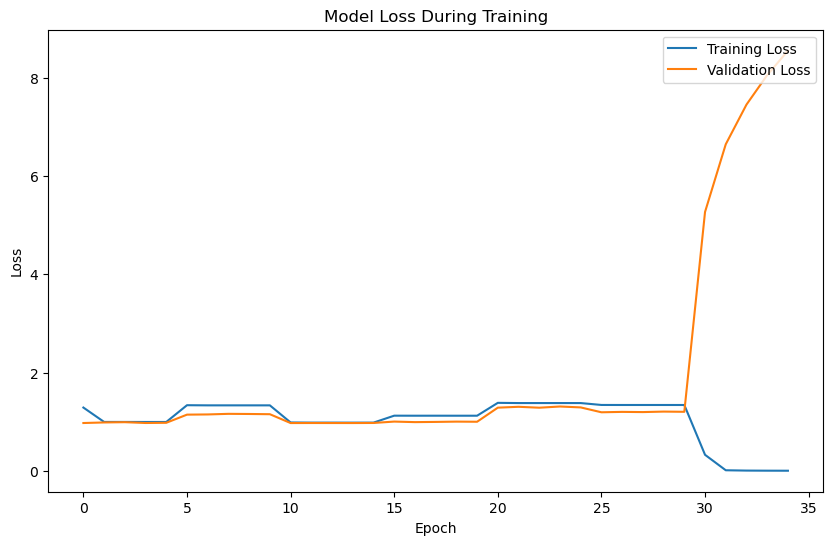

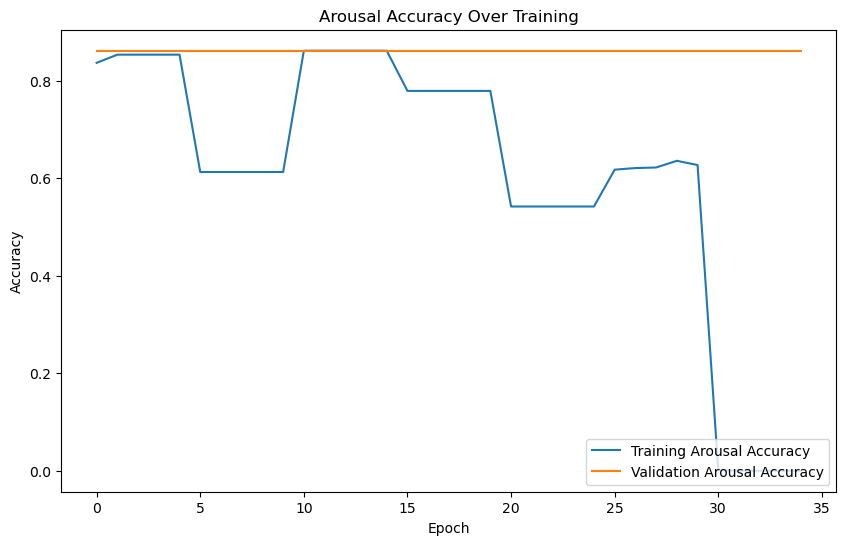

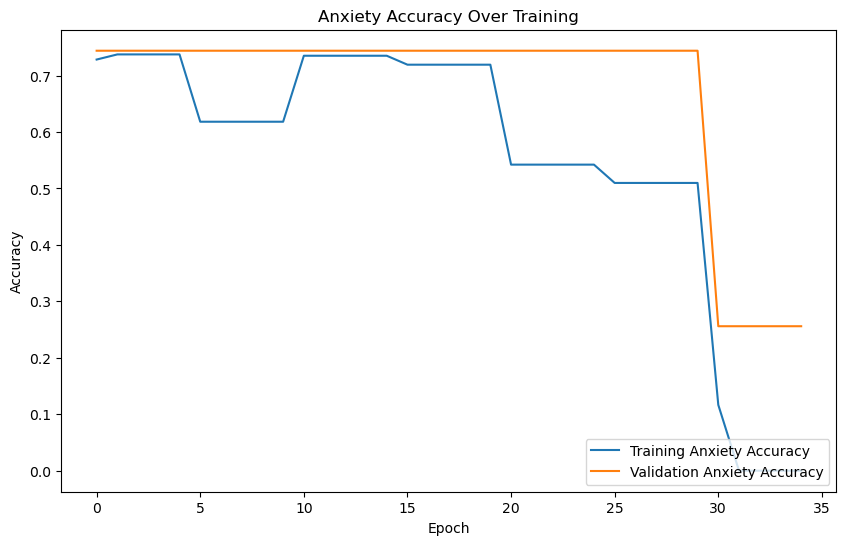

In [3]:
timeStep = 128
input_dim = 32
chunk_size = 100000
outputFilePathS1 = f'C:\\Users\\izaak\Desktop\\VRETDataAnalysis\\Test 1\\totalRawWithLikertS1.csv'
outputFilePathS2 = f'C:\\Users\\izaak\Desktop\\VRETDataAnalysis\\Test 1\\totalRawWithLikertS2.csv'
outputFilePathS3 = f'C:\\Users\\izaak\Desktop\\VRETDataAnalysis\\Test 1\\totalRawWithLikertS3.csv'

model = createLstmModel((timeStep, input_dim))
model.summary()

trainedLstmModel, xTest, arousalTest, anxietyTest = chunkedTraining(model, outputFilePathS1, chunk_size, timeStep)

In [4]:
print(f"xTest shape: {xTest.shape}")
print(f"arousalTest shape: {arousalTest.shape}")
print(f"anxietyTest shape: {anxietyTest.shape}")

xTest shape: (9872, 128, 32)
arousalTest shape: (9872,)
anxietyTest shape: (9872,)


In [5]:
trainedLstmModel.summary()
evaluate_model(trainedLstmModel, xTest, arousalTest, anxietyTest)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 32)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128, 128)  │     82,432 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128)  │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128, 128)  │    131,584 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128)  │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arousal (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anxiety (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 791,176 (3.02 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 527,366 (2.01 MB)

309/309 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - anxiety_accuracy: 0.2582 - anxiety_loss: 6.5146 - arousal_accuracy: 0.8517 - arousal_loss: 1.9871 - loss: 8.5017
Test Loss (Overall): 8.529119491577148
Test Loss (Arousal): 2.026787757873535
Test Loss (Anxiety): 6.500918388366699
Test Accuracy (Arousal): 0.2636750340461731
Test Accuracy (Anxiety): 0.8497771620750427
309/309 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step

Classification Report for Arousal:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8389
           1       0.00      0.00      0.00      1483

    accuracy                           0.85      9872
   macro avg       0.42      0.50      0.46      9872
weighted avg       0.72      0.85      0.78      9872

Classification Report for Anxiety:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7269
           1       0.26      1.00      0.42      2603

    accuracy                  

c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metr

In [6]:
del xTest, arousalTest, anxietyTest 
import gc
gc.collect()

6564

Epoch 1/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 827s 660ms/step - anxiety_accuracy: 0.4564 - anxiety_loss: 1.8498 - arousal_accuracy: 0.9153 - arousal_loss: 0.5316 - loss: 2.3818 - val_anxiety_accuracy: 0.8394 - val_anxiety_loss: 0.3031 - val_arousal_accuracy: 0.9099 - val_arousal_loss: 0.4400 - val_loss: 0.7436 - learning_rate: 3.4056e-04
Epoch 2/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 888s 711ms/step - anxiety_accuracy: 0.8506 - anxiety_loss: 0.3034 - arousal_accuracy: 0.9135 - arousal_loss: 0.4229 - loss: 0.7264 - val_anxiety_accuracy: 0.8394 - val_anxiety_loss: 0.3034 - val_arousal_accuracy: 0.9099 - val_arousal_loss: 0.4412 - val_loss: 0.7451 - learning_rate: 3.4056e-04
Epoch 3/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 827s 662ms/step - anxiety_accuracy: 0.8508 - anxiety_loss: 0.2998 - arousal_accuracy: 0.9146 - arousal_loss: 0.4225 - loss: 0.7225 - val_anxiety_accuracy: 0.8394 - val_anxiety_loss: 0.3035 - val_arousal_accuracy: 0.9099 - val_arousal_loss: 0.4399 - val_loss: 0.7439 - learning_rate: 3.2353

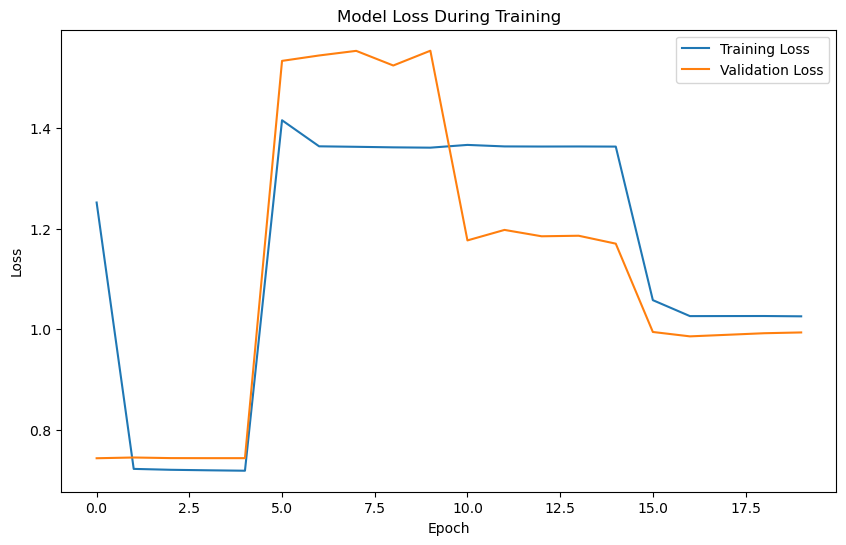

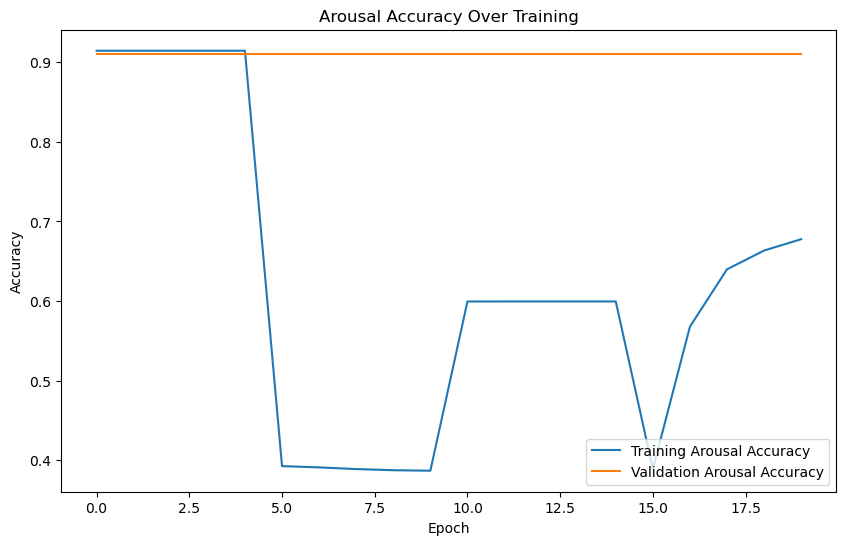

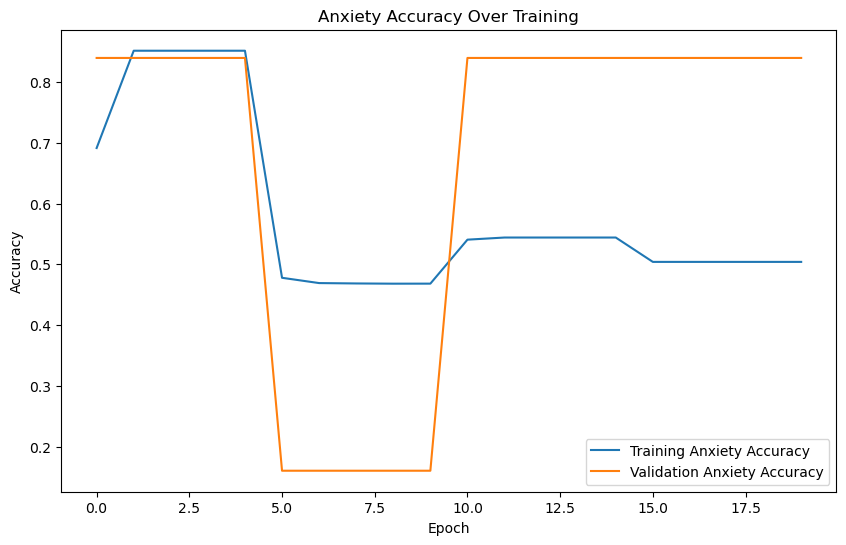

In [7]:
timeStep = 128
input_dim = 32
chunk_size = 100000

trainedLstmModel, xTest, arousalTest, anxietyTest = chunkedTraining(trainedLstmModel, outputFilePathS2, chunk_size, timeStep)

In [8]:
trainedLstmModel.summary()

evaluate_model(trainedLstmModel, xTest, arousalTest, anxietyTest)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 32)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128, 128)  │     82,432 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128)  │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128, 128)  │    131,584 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128)  │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arousal (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anxiety (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 791,176 (3.02 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 527,366 (2.01 MB)

309/309 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step - anxiety_accuracy: 0.8438 - anxiety_loss: 0.3080 - arousal_accuracy: 0.9079 - arousal_loss: 0.6900 - loss: 0.9980
Test Loss (Overall): 0.9879864454269409
Test Loss (Arousal): 0.6899418234825134
Test Loss (Anxiety): 0.2979286015033722
Test Accuracy (Arousal): 0.8499797582626343
Test Accuracy (Anxiety): 0.9124797582626343
309/309 ━━━━━━━━━━━━━━━━━━━━ 47s 151ms/step

Classification Report for Arousal:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9008
           1       0.00      0.00      0.00       864

    accuracy                           0.91      9872
   macro avg       0.46      0.50      0.48      9872
weighted avg       0.83      0.91      0.87      9872

Classification Report for Anxiety:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8391
           1       0.00      0.00      0.00      1481

    accuracy               

c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metr

In [9]:
del xTest, arousalTest, anxietyTest 
gc.collect()

7613

Epoch 1/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 1051s 839ms/step - anxiety_accuracy: 0.8643 - anxiety_loss: 0.5553 - arousal_accuracy: 0.7603 - arousal_loss: 0.4987 - loss: 1.0540 - val_anxiety_accuracy: 0.8623 - val_anxiety_loss: 0.5517 - val_arousal_accuracy: 0.7598 - val_arousal_loss: 0.4007 - val_loss: 0.9521 - learning_rate: 1.8403e-04
Epoch 2/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 1006s 806ms/step - anxiety_accuracy: 0.8640 - anxiety_loss: 0.5492 - arousal_accuracy: 0.7624 - arousal_loss: 0.3985 - loss: 0.9477 - val_anxiety_accuracy: 0.8623 - val_anxiety_loss: 0.5518 - val_arousal_accuracy: 0.7598 - val_arousal_loss: 0.4006 - val_loss: 0.9521 - learning_rate: 1.8403e-04
Epoch 3/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 988s 792ms/step - anxiety_accuracy: 0.8651 - anxiety_loss: 0.5461 - arousal_accuracy: 0.7647 - arousal_loss: 0.3968 - loss: 0.9429 - val_anxiety_accuracy: 0.8623 - val_anxiety_loss: 0.5517 - val_arousal_accuracy: 0.7598 - val_arousal_loss: 0.4006 - val_loss: 0.9520 - learning_rate: 1.74

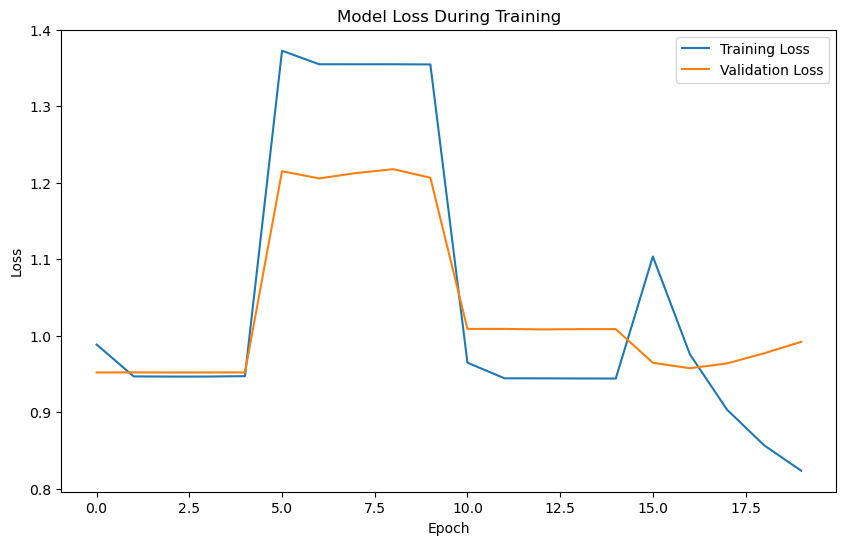

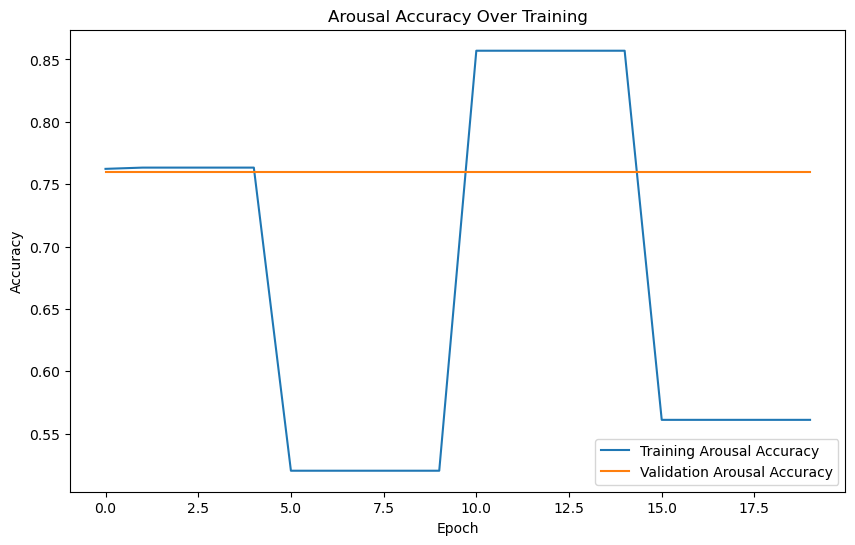

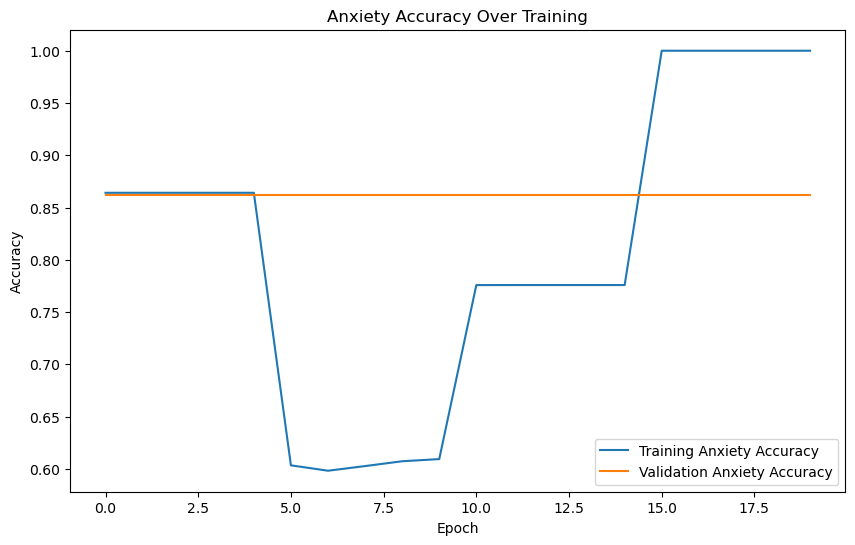

In [10]:
timeStep = 128
input_dim = 32
chunk_size = 100000

trainedModelFull, xTest, arousalTest, anxietyTest = chunkedTraining(trainedLstmModel, outputFilePathS3, chunk_size, timeStep)

In [11]:
trainedModelFull.summary()

evaluate_model(trainedModelFull, xTest, arousalTest, anxietyTest)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 32)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128, 128)  │     82,432 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128)  │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128, 128)  │    131,584 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128)  │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arousal (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anxiety (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 791,176 (3.02 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 527,366 (2.01 MB)

309/309 ━━━━━━━━━━━━━━━━━━━━ 48s 156ms/step - anxiety_accuracy: 0.8688 - anxiety_loss: 0.5848 - arousal_accuracy: 0.7616 - arousal_loss: 0.3924 - loss: 0.9773
Test Loss (Overall): 0.9752975702285767
Test Loss (Arousal): 0.39057305455207825
Test Loss (Anxiety): 0.5847018957138062
Test Accuracy (Arousal): 0.869631290435791
Test Accuracy (Anxiety): 0.7618517279624939
309/309 ━━━━━━━━━━━━━━━━━━━━ 44s 142ms/step

Classification Report for Arousal:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7521
           1       0.00      0.00      0.00      2351

    accuracy                           0.76      9872
   macro avg       0.38      0.50      0.43      9872
weighted avg       0.58      0.76      0.66      9872

Classification Report for Anxiety:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      8585
           1       0.00      0.00      0.00      1287

    accuracy               

c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metr

In [12]:
del trainedLstmModel

In [4]:
def createGruModel(inputShape):
    modelInput = Input(shape=inputShape)
    
    x = GRU(128, return_sequences=True, kernel_regularizer='l2')(modelInput)
    x = Dropout(0.3)(x)
    x = GRU(128, return_sequences=True, kernel_regularizer='l2')(x)
    x = Dropout(0.3)(x)
    x = GRU(64, return_sequences=False, kernel_regularizer='l2')(x)
    x = BatchNormalization()(x)
    # Output layers
    output_arousal = Dense(1, activation='sigmoid', name='arousal')(x)
    output_anxiety = Dense(1, activation='sigmoid', name='anxiety')(x)
    
    # Create and compile model
    model = Model(inputs=modelInput, outputs=[output_arousal, output_anxiety])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss={'arousal': 'binary_crossentropy', 
                        'anxiety': 'binary_crossentropy'}, 
                  metrics={'arousal': ['accuracy'], 'anxiety': ['accuracy']})
    return model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 32)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 128, 128)  │     62,208 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128)  │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 128, 128)  │     99,072 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128)  │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 64)        │     37,248 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ gru_2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arousal (Dense)     │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anxiety (Dense)     │ (None, 1)         │         65 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 198,914 (777.01 KB)

 Trainable params: 198,786 (776.51 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 721s 565ms/step - anxiety_accuracy: 0.7057 - anxiety_loss: 0.4883 - arousal_accuracy: 0.7788 - arousal_loss: 0.6176 - loss: 1.9184 - val_anxiety_accuracy: 0.7412 - val_anxiety_loss: 0.4091 - val_arousal_accuracy: 0.8576 - val_arousal_loss: 0.5708 - val_loss: 0.9867 - learning_rate: 0.0010
Epoch 2/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 598s 479ms/step - anxiety_accuracy: 0.7370 - anxiety_loss: 0.4185 - arousal_accuracy: 0.8533 - arousal_loss: 0.5777 - loss: 1.0022 - val_anxiety_accuracy: 0.7412 - val_anxiety_loss: 0.4306 - val_arousal_accuracy: 0.8576 - val_arousal_loss: 0.6133 - val_loss: 1.0454 - learning_rate: 0.0010
Epoch 3/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 563s 451ms/step - anxiety_accuracy: 0.7391 - anxiety_loss: 0.4156 - arousal_accuracy: 0.8542 - arousal_loss: 0.5742 - loss: 0.9900 - val_anxiety_accuracy: 0.7412 - val_anxiety_loss: 0.4116 - val_arousal_accuracy: 0.8576 - val_arousal_loss: 0.5774 - val_loss: 0.9907 - learning_rate: 9.5000e-04
Epo

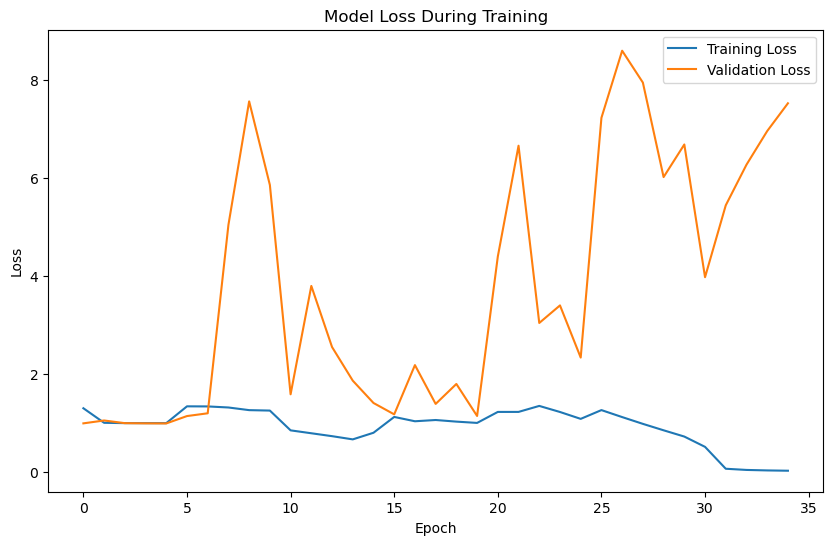

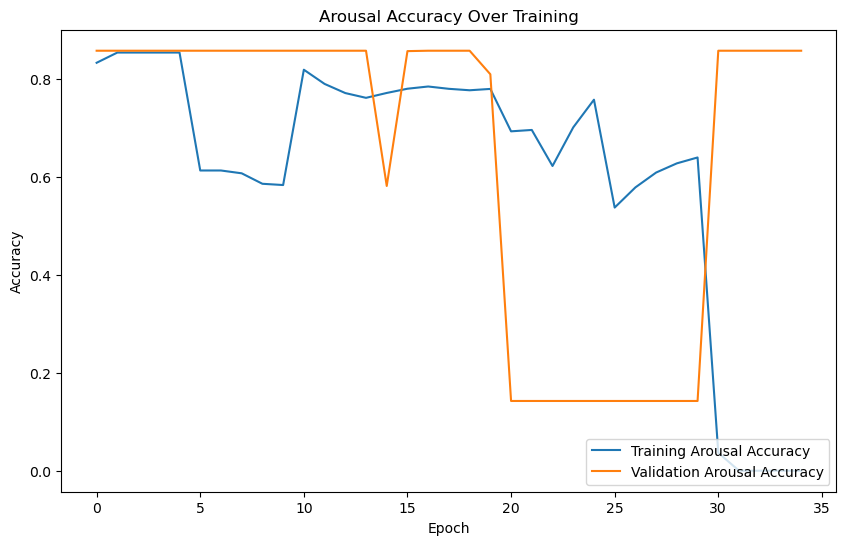

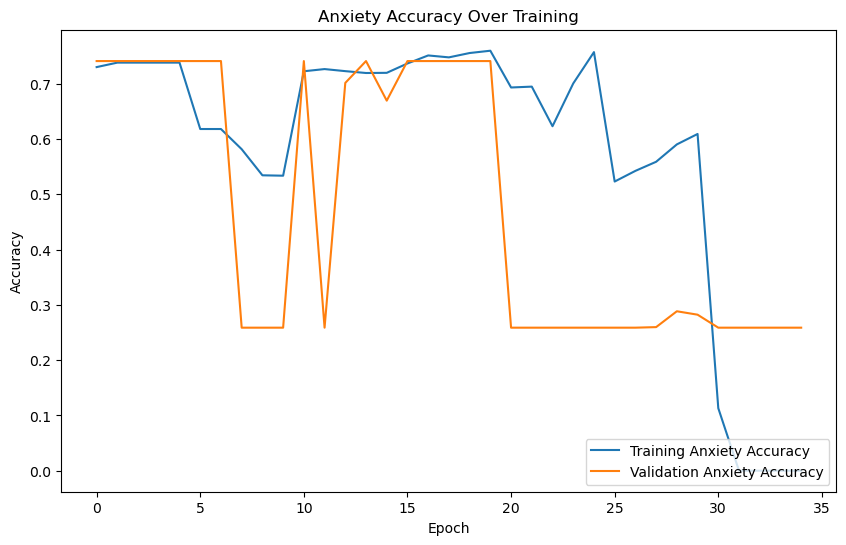

In [5]:
timeStep = 128
input_dim = 32
chunk_size = 100000
outputFilePathS1 = f'C:\\Users\\izaak\Desktop\\VRETDataAnalysis\\Test 1\\totalRawWithLikertS1.csv'
outputFilePathS2 = f'C:\\Users\\izaak\Desktop\\VRETDataAnalysis\\Test 1\\totalRawWithLikertS2.csv'
outputFilePathS3 = f'C:\\Users\\izaak\Desktop\\VRETDataAnalysis\\Test 1\\totalRawWithLikertS3.csv'

model = createGruModel((timeStep, input_dim))
model.summary()

trainedGruModel, xTest, arousalTest, anxietyTest = chunkedTraining(model, outputFilePathS1, chunk_size, timeStep)

In [6]:
trainedGruModel.summary()
evaluate_model(trainedGruModel, xTest, arousalTest, anxietyTest)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 32)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 128, 128)  │     62,208 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128)  │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 128, 128)  │     99,072 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128)  │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 64)        │     37,248 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ gru_2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arousal (Dense)     │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anxiety (Dense)     │ (None, 1)         │         65 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 596,488 (2.28 MB)

 Trainable params: 198,786 (776.51 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 397,574 (1.52 MB)

309/309 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - anxiety_accuracy: 0.2661 - anxiety_loss: 5.6237 - arousal_accuracy: 0.8585 - arousal_loss: 1.9488 - loss: 7.5864
Test Loss (Overall): 7.5712714195251465
Test Loss (Arousal): 1.97931969165802
Test Loss (Anxiety): 5.577573776245117
Test Accuracy (Arousal): 0.2697528302669525
Test Accuracy (Anxiety): 0.8518030643463135
309/309 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step

Classification Report for Arousal:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8409
           1       0.00      0.00      0.00      1463

    accuracy                           0.85      9872
   macro avg       0.43      0.50      0.46      9872
weighted avg       0.73      0.85      0.78      9872

Classification Report for Anxiety:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7209
           1       0.27      1.00      0.42      2663

    accuracy                    

c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metr

In [9]:
del xTest, arousalTest, anxietyTest 
import gc
gc.collect()

7523

Epoch 1/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 729s 583ms/step - anxiety_accuracy: 0.5573 - anxiety_loss: 1.4436 - arousal_accuracy: 0.9131 - arousal_loss: 0.5619 - loss: 2.0317 - val_anxiety_accuracy: 0.8560 - val_anxiety_loss: 0.2874 - val_arousal_accuracy: 0.9167 - val_arousal_loss: 0.4679 - val_loss: 0.7664 - learning_rate: 3.4056e-04
Epoch 2/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 647s 518ms/step - anxiety_accuracy: 0.8481 - anxiety_loss: 0.2986 - arousal_accuracy: 0.9118 - arousal_loss: 0.4264 - loss: 0.7344 - val_anxiety_accuracy: 0.8560 - val_anxiety_loss: 0.2874 - val_arousal_accuracy: 0.9167 - val_arousal_loss: 0.4138 - val_loss: 0.7063 - learning_rate: 3.4056e-04
Epoch 3/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 671s 537ms/step - anxiety_accuracy: 0.8488 - anxiety_loss: 0.2932 - arousal_accuracy: 0.9141 - arousal_loss: 0.4250 - loss: 0.7224 - val_anxiety_accuracy: 0.8560 - val_anxiety_loss: 0.2883 - val_arousal_accuracy: 0.9167 - val_arousal_loss: 0.4133 - val_loss: 0.7035 - learning_rate: 3.2353

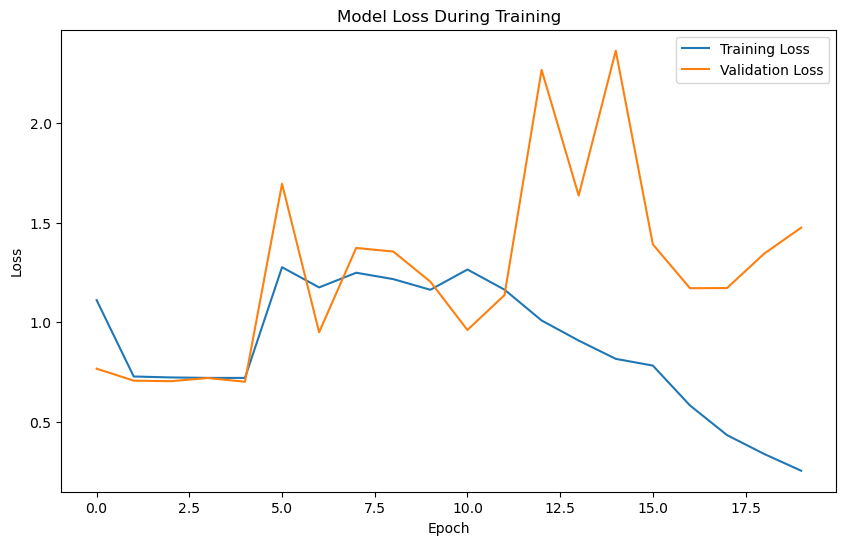

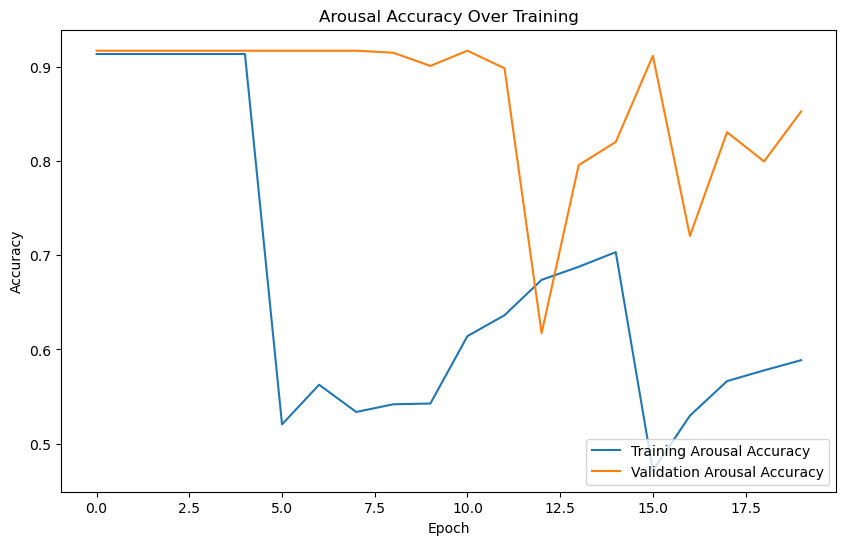

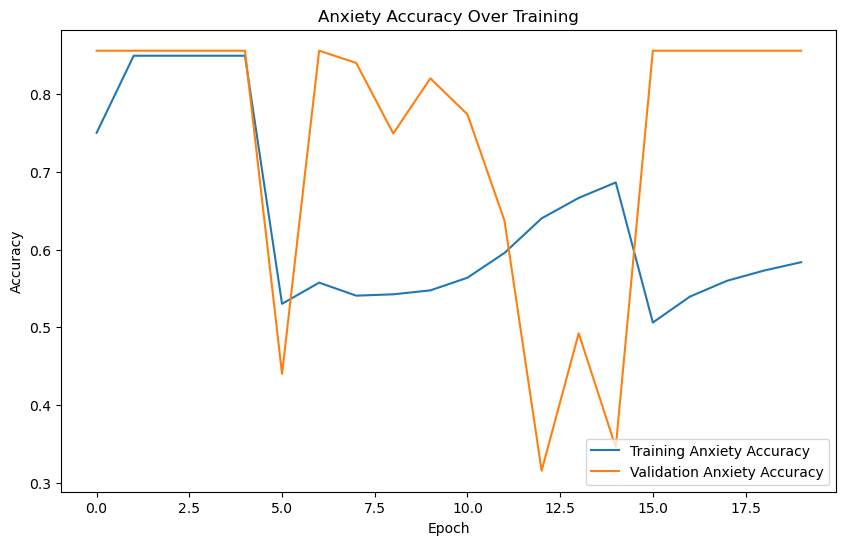

In [10]:
timeStep = 128
input_dim = 32
chunk_size = 100000

trainedGruModel, xTest, arousalTest, anxietyTest = chunkedTraining(trainedGruModel, outputFilePathS2, chunk_size, timeStep)

In [11]:
trainedGruModel.summary()
evaluate_model(trainedGruModel, xTest, arousalTest, anxietyTest)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 32)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 128, 128)  │     62,208 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128)  │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 128, 128)  │     99,072 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128)  │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 64)        │     37,248 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ gru_2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arousal (Dense)     │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anxiety (Dense)     │ (None, 1)         │         65 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 596,488 (2.28 MB)

 Trainable params: 198,786 (776.51 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 397,574 (1.52 MB)

309/309 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - anxiety_accuracy: 0.8495 - anxiety_loss: 0.7059 - arousal_accuracy: 0.7590 - arousal_loss: 0.7516 - loss: 1.5099
Test Loss (Overall): 1.4759244918823242
Test Loss (Arousal): 0.707378625869751
Test Loss (Anxiety): 0.7146217226982117
Test Accuracy (Arousal): 0.8497771620750427
Test Accuracy (Anxiety): 0.7857577204704285
309/309 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step

Classification Report for Arousal:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      9047
           1       0.07      0.13      0.09       825

    accuracy                           0.79      9872
   macro avg       0.49      0.49      0.49      9872
weighted avg       0.84      0.79      0.81      9872

Classification Report for Anxiety:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8389
           1       0.00      0.00      0.00      1483

    accuracy                 

c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
del xTest, arousalTest, anxietyTest 
import gc
gc.collect()

7528

Epoch 1/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 877s 702ms/step - anxiety_accuracy: 0.8622 - anxiety_loss: 0.6847 - arousal_accuracy: 0.7255 - arousal_loss: 0.5102 - loss: 1.2464 - val_anxiety_accuracy: 0.8604 - val_anxiety_loss: 0.5576 - val_arousal_accuracy: 0.7598 - val_arousal_loss: 0.4095 - val_loss: 1.0048 - learning_rate: 1.8403e-04
Epoch 2/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 969s 777ms/step - anxiety_accuracy: 0.8654 - anxiety_loss: 0.5514 - arousal_accuracy: 0.7610 - arousal_loss: 0.3962 - loss: 0.9819 - val_anxiety_accuracy: 0.8604 - val_anxiety_loss: 0.5591 - val_arousal_accuracy: 0.7598 - val_arousal_loss: 0.4125 - val_loss: 0.9987 - learning_rate: 1.8403e-04
Epoch 3/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 930s 735ms/step - anxiety_accuracy: 0.8667 - anxiety_loss: 0.5507 - arousal_accuracy: 0.7612 - arousal_loss: 0.3935 - loss: 0.9693 - val_anxiety_accuracy: 0.8604 - val_anxiety_loss: 0.5526 - val_arousal_accuracy: 0.7598 - val_arousal_loss: 0.4128 - val_loss: 0.9861 - learning_rate: 1.7482

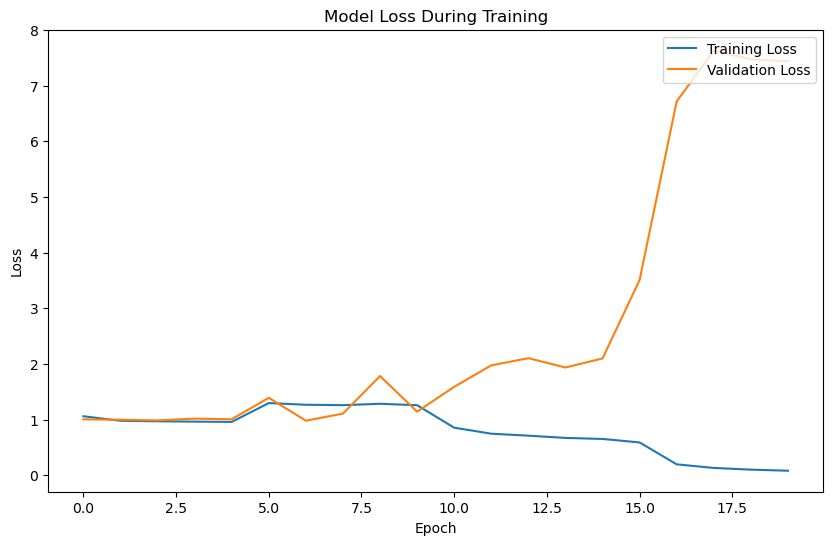

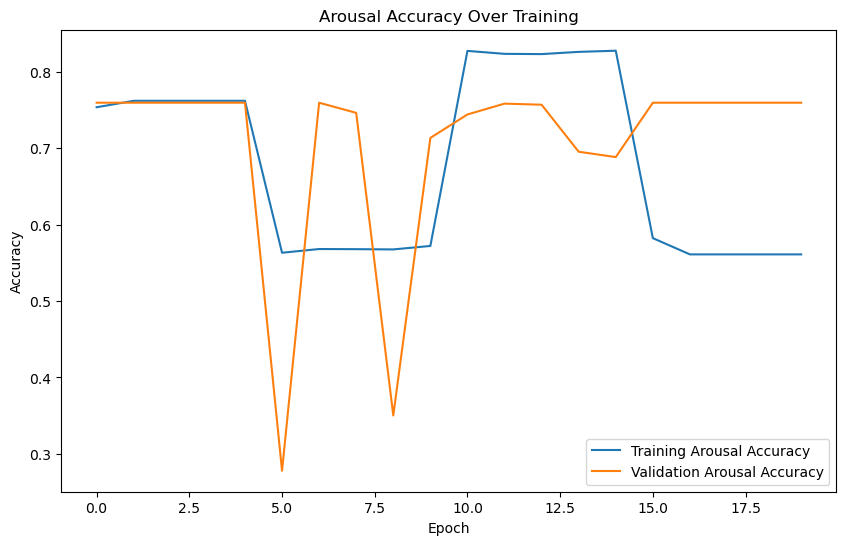

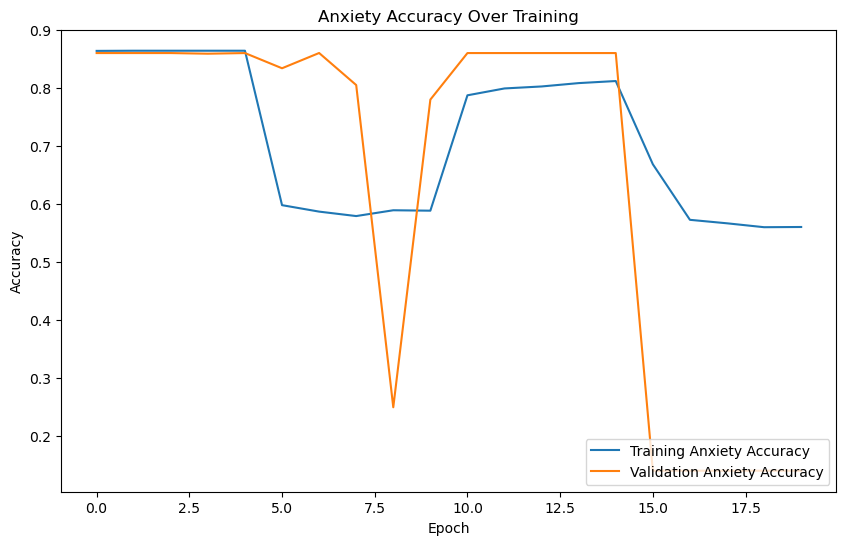

In [13]:
timeStep = 128
input_dim = 32
chunk_size = 100000

trainedGruModel, xTest, arousalTest, anxietyTest = chunkedTraining(trainedGruModel, outputFilePathS3, chunk_size, timeStep)

In [14]:
trainedGruModel.summary()
evaluate_model(trainedGruModel, xTest, arousalTest, anxietyTest)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 32)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 128, 128)  │     62,208 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128)  │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 128, 128)  │     99,072 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128)  │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 64)        │     37,248 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ gru_2[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arousal (Dense)     │ (None, 1)         │         65 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anxiety (Dense)     │ (None, 1)         │         65 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 596,488 (2.28 MB)

 Trainable params: 198,786 (776.51 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 397,574 (1.52 MB)

309/309 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - anxiety_accuracy: 0.1340 - anxiety_loss: 7.0480 - arousal_accuracy: 0.7715 - arousal_loss: 0.5050 - loss: 7.5841
Test Loss (Overall): 7.597618103027344
Test Loss (Arousal): 0.4947618544101715
Test Loss (Anxiety): 7.07017183303833
Test Accuracy (Arousal): 0.13148298859596252
Test Accuracy (Anxiety): 0.7696515321731567
309/309 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step

Classification Report for Arousal:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      7598
           1       0.00      0.00      0.00      2274

    accuracy                           0.77      9872
   macro avg       0.38      0.50      0.43      9872
weighted avg       0.59      0.77      0.67      9872

Classification Report for Anxiety:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8574
           1       0.13      1.00      0.23      1298

    accuracy                   

c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\izaak\anaconda3\Lib\site-packages\sklearn\metr

In [15]:
del trainedGruModel, xTest, arousalTest, anxietyTest 
gc.collect()

7986

In [16]:
def createBiLstmModel(inputShape):
    modelInput = Input(shape=inputShape)
    
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer='l2'))(modelInput)
    x = Dropout(0.25)(x)
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer='l2'))(x)
    x = Dropout(0.25)(x)
    x = Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer='l2'))(x)
    x = BatchNormalization()(x)
    # Output layers
    output_arousal = Dense(1, activation='sigmoid', name='arousal')(x)
    output_anxiety = Dense(1, activation='sigmoid', name='anxiety')(x)
    
    # Create and compile model
    model = Model(inputs=modelInput, outputs=[output_arousal, output_anxiety])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss={'arousal': 'binary_crossentropy', 
                        'anxiety': 'binary_crossentropy'}, 
                  metrics={'arousal': ['accuracy'], 'anxiety': ['accuracy']})
    return model

In [17]:
timeStep = 128
input_dim = 32
chunk_size = 100000
outputFilePathS1 = f'C:\\Users\\izaak\Desktop\\VRETDataAnalysis\\Test 1\\totalRawWithLikertS1.csv'
outputFilePathS2 = f'C:\\Users\\izaak\Desktop\\VRETDataAnalysis\\Test 1\\totalRawWithLikertS2.csv'
outputFilePathS3 = f'C:\\Users\\izaak\Desktop\\VRETDataAnalysis\\Test 1\\totalRawWithLikertS3.csv'

model = createBiLstmModel((timeStep, input_dim))
model.summary()

trainedBilstmModel, xTest, arousalTest, anxietyTest = chunkedTraining(model, outputFilePathS1, chunk_size, timeStep)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 32)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 256)  │    164,864 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 256)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128, 256)  │    394,240 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 256)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 128)       │    164,352 │ dropout_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arousal (Dense)     │ (None, 1)         │        129 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anxiety (Dense)     │ (None, 1)         │        129 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 724,226 (2.76 MB)

 Trainable params: 723,970 (2.76 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 2181s 2s/step - anxiety_accuracy: 0.7143 - anxiety_loss: 0.4707 - arousal_accuracy: 0.7957 - arousal_loss: 0.6074 - loss: 2.9398 - val_anxiety_accuracy: 0.7397 - val_anxiety_loss: 0.4098 - val_arousal_accuracy: 0.8576 - val_arousal_loss: 0.5740 - val_loss: 0.9838 - learning_rate: 0.0010
Epoch 2/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 2042s 2s/step - anxiety_accuracy: 0.7374 - anxiety_loss: 0.4194 - arousal_accuracy: 0.8522 - arousal_loss: 0.5764 - loss: 0.9972 - val_anxiety_accuracy: 0.7397 - val_anxiety_loss: 0.6480 - val_arousal_accuracy: 0.8563 - val_arousal_loss: 0.6899 - val_loss: 1.3578 - learning_rate: 0.0010
Epoch 3/5
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 2080s 2s/step - anxiety_accuracy: 0.7378 - anxiety_loss: 0.4166 - arousal_accuracy: 0.8538 - arousal_loss: 0.5758 - loss: 0.9963 - val_anxiety_accuracy: 0.7397 - val_anxiety_loss: 0.4200 - val_arousal_accuracy: 0.8576 - val_arousal_loss: 0.5740 - val_loss: 0.9952 - learning_rate: 9.5000e-04
Epoch 4/5

In [ ]:
trainedBilstmModel.summary()
evaluate_model(trainedBilstmModel, xTest, arousalTest, anxietyTest)

In [ ]:
del xTest, arousalTest, anxietyTest 
gc.collect()

In [ ]:
timeStep = 128
chunk_size = 100000

trainedBilstmModel, xTest, arousalTest, anxietyTest = chunkedTraining(trainedBilstmModel, outputFilePathS2, chunk_size, timeStep)

In [ ]:
trainedBilstmModel.summary()
evaluate_model(trainedBilstmModel, xTest, arousalTest, anxietyTest)

In [ ]:
del xTest, arousalTest, anxietyTest 
gc.collect()

In [ ]:
timeStep = 128
chunk_size = 100000

trainedBilstmModel, xTest, arousalTest, anxietyTest = chunkedTraining(trainedBilstmModel, outputFilePathS3, chunk_size, timeStep)

In [ ]:
trainedBilstmModel.summary()
evaluate_model(trainedBilstmModel, xTest, arousalTest, anxietyTest)

In [ ]:
del trainedBilstmModel, xTest, arousalTest, anxietyTest 
gc.collect()